# TSP in Gurobi

> Python 3.9.16
>
> MacBook Pro M2 Apple Silicon

## 一、基础的TSP模型

In [1]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import gurobipy as grb

In [2]:
# 计算欧氏距离
def Eculid_dist(a, b):
    return math.sqrt((a[0] - b[0]) * (a[0] - b[0]) + (a[1] - b[1])*(a[1] - b[1]))

#  随机数生成函数
def rndPoints(N, lb, ub, nodeID = None, rndSeed = 10):
    """_summary_

    Args:
        N (_type_): 节点的数字
        lb (_type_): 坐标的下限
        ub (_type_): 坐标的上限
        nodeID (_type_): 节点的ID
        rndSeed (_type_): 随机数种子
    """
    
    nodes_pos = []
    
    np.random.seed(rndSeed)
    
    poly_x = np.random.uniform(lb, ub, N)
    poly_y = np.random.uniform(lb, ub, N)
    
    for i in range(N):
        nodes_pos.append((round(poly_x[i], 2), round(poly_y[i], 2)))
    
    if nodeID == None or not isinstance(nodeID, list):
        nodeID = [str(i) for i in range(N)]
    else:
        if len(nodeID) != N:
            raise Exception("检查nodeID 长度和 N 是否相等")

    return nodes_pos, nodeID


# TODO: 加入nodeID, 补充一点工程化的内容


def visualize(nodes_pos, lb, ub, edges = None, save_path = '../image/result.png'):
    """_summary_

    Args:
        nodes_pos (_type_): 节点的坐标 list( tuple(coord_x, coord_y))
        lb (_type_): 坐标的下界
        ub (_type_): 坐标的上界
        edges (_type_, optional): 边数据 list( list (org_id, dst_id))
        save_path (str, optional): _description_. Defaults to './test_pic1.png'.

    Raises:
        Exception: _description_
    
    """
    plt.style.use('_mpl-gallery')
    # colors = 
    fig, ax = plt.subplots(figsize = (6,6))
    
    ax.scatter(
        x = [node[0] for node in nodes_pos], 
        y = [node[1] for node in nodes_pos], 
        s = [6 for _ in range(len(nodes_pos))],
        c = ["r" for _ in range(len(nodes_pos))],
        # vmin = lb,
        # vmax = ub
    )
    
    ax.set(
        xlim = (lb - max(lb*0.1, 10), ub + 10),
        ylim = (lb - max(lb*0.1, 10), ub + 10)
    )
    
    if edges == None:
        pass
    else:
        for e in edges:
            ax.plot([nodes_pos[e[0]][0], nodes_pos[e[1]][0]],[nodes_pos[e[0]][1], nodes_pos[e[1]][1]] , "lightgreen", linewidth = 2)
    ax.grid(False)
    fig.tight_layout()
    
    try:
        plt.savefig(save_path, dpi = 400)
        print(f"保存成功，路径{save_path}")

    except Exception:
        raise Exception(f"图片保存失败，路径 {save_path}，检查路径。")

    return 

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 60 rows, 870 columns and 1740 nonzeros
Model fingerprint: 0x443136fb
Variable types: 0 continuous, 870 integer (870 binary)


Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
The length is 2
Presolve time: 0.01s
Presolved: 60 rows, 870 columns, 1740 nonzeros
Variable types: 0 continuous, 870 integer (870 binary)
The length is 14
The length is 15

Root relaxation: objective 3.978723e+02, 84 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  397.87228    0   14          -  397.87228      -     -    0s
The length is 10
The length is 5
The length is 2
The length is 1
H    0     0                     564.0669649  397.87228  29.5%     -    0s
The length is 3
The length is 1
H    0     0                     547.0960909  397.87228  27.3%     -    0s
The length is 5
     0     0  439.92816    0    -  547.09609  439.92816  19.6%     -    0s
The length is 

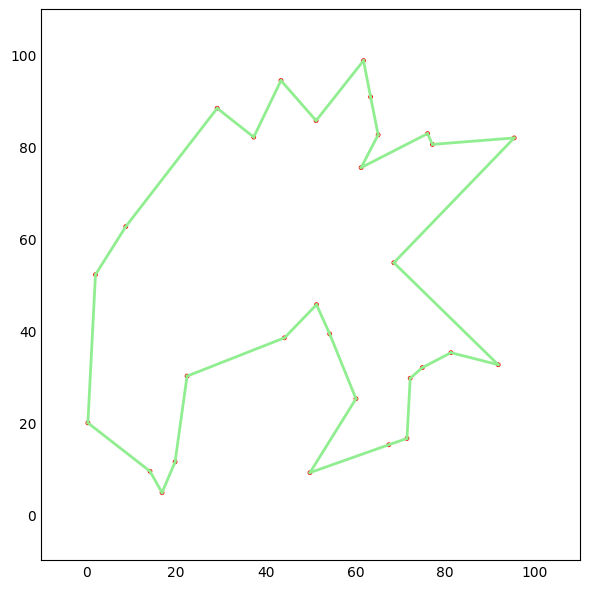

In [3]:
def TSPwithLazyCuts(nodes_pos):

    adj_matrix = [
        [0 for _ in range(len(nodes_pos))] for _ in range(len(nodes_pos))
    ]

    # adjacent matrice

    N = len(nodes_pos)

    # number of nodes

    TSP = grb.Model('TSP')

    # Decision Variables ======================== 

    x = {}

    for i in range(N):
        for j in range(N):
            if i != j:
                x[i, j] = TSP.addVar(
                    vtype = grb.GRB.BINARY,
                    obj = Eculid_dist(nodes_pos[i], nodes_pos[j]),
                    name = f"x_{i}_{j}"
                )
                adj_matrix[i][j] = Eculid_dist(nodes_pos[i], nodes_pos[j])

    TSP.modelSense = grb.GRB.MINIMIZE
    TSP.Params.lazyConstraints = 1
    TSP.update()

    # Decision Variables ======================== 
            
    # Constraints ==========

    # Degree constraints ======================================================
    for i in range(N):
        TSP.addConstr(grb.quicksum(x[i, j] for j in range(N) if i != j) == 1, name = 'leave_%s' % str(i))
        TSP.addConstr(grb.quicksum(x[j, i] for j in range(N) if i != j) == 1, name = 'enter_%s' % str(i))
        
    TSP._x = x

    # 在模型求解中声明的自己的变量？

    def subtourelim(model, where):
        if (where == grb.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            # 从新的 MIP 解决方案中检索值。
            G = nx.Graph()
            for (i, j) in x.keys():
                if (x_sol[i, j] > 0.9):
                    G.add_edge(i, j, weight = adj_matrix[i][j])
            components = [list(c) for c in nx.connected_components(G)]
            print("The length is " + str(len(components)))
            for component in components:
                if (len(component) < N):
                    model.cbLazy(grb.quicksum(x[i,j] for i in component for j in component if i != j) <= len(component) - 1)
                    
                    # 这里相当于在原来的有环的情况上加了一个约束进去

    # TSP with callback =======================================================
    
    TSP.optimize(subtourelim)
    # TSP.write("models.lp")

    ofv = None
    seq = []
    arcs = []
    solType = None
    gap = None
    lb = None
    ub = None
    runtime = None
    if (TSP.status == grb.GRB.status.OPTIMAL):
        solType = 'IP_Optimal'
        ofv = TSP.getObjective().getValue()
        print(ofv)
        for i, j in x:
            if (x[i, j].x > 0.5):
                arcs.append([i, j])
        # assert len(arcs) == len(nodes_pos) - 1
        # currentNode = nodeIDs[0]
        # seq.append(currentNode)
        # while (len(arcs) > 0):
        #     for i in range(len(arcs)):
        #         if (arcs[i][0] == currentNode):
        #             currentNode = arcs[i][1]
        #             seq.append(currentNode)
        #             arcs.pop(i)
        #             break
        gap = 0
        lb = ofv
        ub = ofv
        runtime = TSP.Runtime
    elif (TSP.status == grb.GRB.status.TIME_LIMIT):
        solType = 'IP_TimeLimit'
        ofv = None
        seq = []
        gap = TSP.MIPGap
        lb = TSP.ObjBoundC
        ub = TSP.ObjVal
        runtime = TSP.Runtime
    
    return {
        "TotalCost": ofv,
        "runtime": runtime,
        "arcs": arcs
    }

# print({
#         'ofv': ofv,
#         'seq': seq,
#         'gap': gap,
#         'solType': solType,
#         'lowerBound': lb,
#         'upperBound': ub,
#         'runtime': runtime
# })

if __name__ == "__main__":
    nodes, nodeID = rndPoints(30, 0, 100)
    arcs = TSPwithLazyCuts(nodes)["arcs"]
    visualize(nodes, 0, 100, arcs)
    
    # nodes, nodeID = rndPoints(30, 0, 100, 2912) 
    # 测试
    


cbLazy 是什么？

- [参考链接](https://www.gurobi.com/documentation/10.0/refman/py_model_cblazy.html):从回调函数中向 MIP 模型添加新的惰性约束。当 MIP 模型的完整约束集太大而无法显式表示时，通常使用延迟约束。通过仅包括在分支和切割搜索期间找到的解决方案实际违反的约束，有时可以找到经过验证的最佳解决方案，同时只添加整套约束的一小部分。
- LazyConstraint 参数一定要设置


- nx.connected_components: 怎么理解？
> 获取网络中的联通子图，按照子图大小从大到小输出


怎么理解Gurobi中的Callback函数？

> 回调是由 Gurobi 优化器定期调用的用户函数，以允许用户查询或修改优化的状态。更准确地说，如果将两个参数（ model 和 where ）作为参数的函数传递给 Model.optimize 或 Model.computeIIS，则在优化期间将调用您的函数。[链接](https://www.gurobi.com/documentation/current/refman/py_cb_s.html#pythonclass:Callback). Gurobi 回调类提供一组在用户回调函数中使用的常量。此类中的第一组常量列出了用户回调函数的 where 参数选项。该 where 参数指示从优化过程中调用用户回调的位置。选项列于本文档的回调代码部分. [参考链接](https://support.gurobi.com/hc/en-us/articles/14126389733777-Tutorial-Customization-Through-Callbacks)

--------


解释一下`nx.connected_components`. 这里用到了经典的图网络分析的包 networkx。

在图中，这个方法可以搜索并按照从大到小输出所有的联通分量。下面我们的图中有3个联通分量，分别是10-11-12-13-14相连接、4-5-9相互连接以及0-1-2-3相互连接。用这个方法可以把这三个联通分量全部输出出来。

[{10, 11, 12, 13, 14}, {0, 1, 2, 3}, {9, 4, 5}]


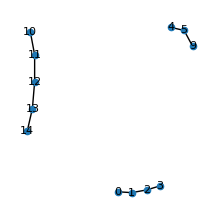

In [58]:
# TO explain nx.connected_components

G = nx.path_graph(4)
nx.add_path(G, [4, 5 ,9])
nx.add_path(G, [10,11,12,13,14])

a = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
nx.draw(G, node_size = 20, with_labels = True, font_size = 8)
print(a)

## MTZ implementation

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1640 rows, 1600 columns and 7644 nonzeros
Model fingerprint: 0x3ccd7621
Variable types: 40 continuous, 1560 integer (1560 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 78 rows and 1 columns
Presolve time: 0.01s
Presolved: 1562 rows, 1599 columns, 7566 nonzeros
Variable types: 39 continuous, 1560 integer (1560 binary)
Found heuristic solution: objective 2011.9634110
Found heuristic solution: objective 1988.6219153

Root relaxation: objective 4.158563e+02, 154 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  41

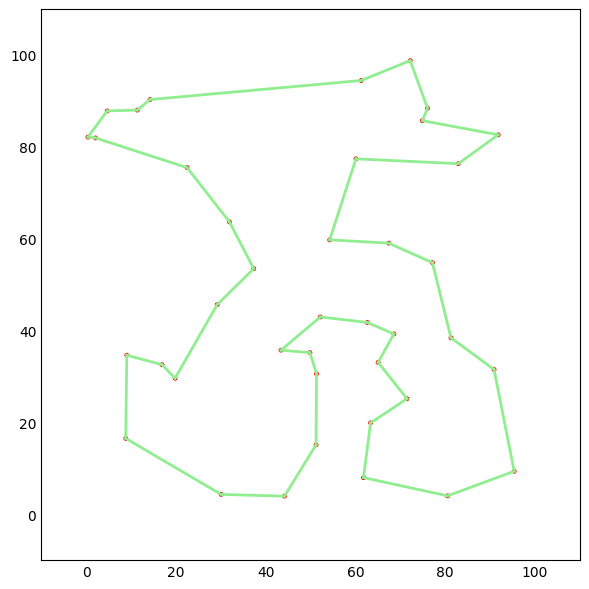

In [4]:
# def _ipTSPGurobiMTZ(nodeIDs, tau, outputFlag, timeLimit, gapTolerance):
def TSP_Guribi_MTZ(nodeIDs, nodes_pos):
    
    # Initialize
    
    N = len(nodeIDs)
    TSP = grb.Model('TSP')
    
    # if (outputFlag == False):
    #     TSP.setParam('OutputFlag', 0)
    # if (timeLimit != None):
    #     TSP.setParam(grb.GRB.Param.TimeLimit, timeLimit)
    # if (gapTolerance != None):
    #     TSP.setParam(grb.GRB.Param.MIPGap, gapTolerance)

    # Decision variables ======================================================
    # x = {}
    # for i in range(n):
    #     for j in range(n):
    #         if i != j:
    #             x[i, j] = TSP.addVar(
    #                 vtype = grb.GRB.BINARY, 
    #                 obj = tau[nodeIDs[i], nodeIDs[j]], 
    #                 name = 'x_%s_%s' % (i, j))
    
    x = dict()
    
    adj_matrix = [
        [0 for _ in range(len(nodes_pos))] for _ in range(len(nodes_pos))
    ]
    
    for i in range(N):
        for j in range(N):
            if i != j:
                adj_matrix[i][j] = Eculid_dist(nodes_pos[i], nodes_pos[j])
                x[i, j] = TSP.addVar(
                    vtype = grb.GRB.BINARY,
                    obj = adj_matrix[i][j],
                    name = f"x_{i}_{j}"
                )
                

    u = dict()
    for i in range(N):
        u[i] = TSP.addVar(
            vtype = grb.GRB.CONTINUOUS,
            name = 'u_%s' % (i))

    # TSP objective function ==================================================
    TSP.modelSense = grb.GRB.MINIMIZE
    TSP.update()

    # Degree constraints ======================================================
    for i in range(N):
        TSP.addConstr(grb.quicksum(x[i, j] for j in range(N) if i != j) == 1, name = 'leave_%s' % str(i))
        TSP.addConstr(grb.quicksum(x[j, i] for j in range(N) if i != j) == 1, name = 'enter_%s' % str(i))

    # Sequence constraints ====================================================
    for i in range(1, N):
        for j in range(1, N):
            if (i != j):
                TSP.addConstr(u[i] - u[j] + (N - 1) * x[i, j] <= N - 2, name = 'seq_%s_%s' % (i, j))
    for i in range(1, N):
        TSP.addConstr(1 <= u[i])
        TSP.addConstr(u[i] <= N - 1)

    # TSP =====================================================================
    TSP.optimize()

    # Reconstruct solution ====================================================
    ofv = None
    gap = None
    seq = []
    arcs = []
    solType = None
    gap = None
    lb = None
    ub = None
    runtime = None
    if (TSP.status == grb.GRB.status.OPTIMAL):
        solType = 'IP_Optimal'
        ofv = TSP.getObjective().getValue()
        gap = TSP.Params.MIPGapAbs
        for i, j in x:
            if (x[i, j].x > 0.5):
                arcs.append([i, j])
        
        # currentNode = 0
        # seq.append(nodeIDs[currentNode])
        # while (len(arcs) > 0):
        #     for i in range(len(arcs)):
        #         if (arcs[i][0] == currentNode):
        #             currentNode = arcs[i][1]
        #             seq.append(nodeIDs[currentNode])
        #             arcs.pop(i)
        #             break
        
        gap = 0
        lb = ofv
        ub = ofv
        runtime = TSP.Runtime
    elif (TSP.status == grb.GRB.status.TIME_LIMIT):
        solType = 'IP_TimeLimit'
        ofv = None
        seq = []
        gap = TSP.MIPGap
        lb = TSP.ObjBoundC
        ub = TSP.ObjVal
        runtime = TSP.Runtime

    return {
        'ofv': ofv,
        'seq': seq,
        'gap': gap,
        'solType': solType,
        'lowerBound': lb,
        'upperBound': ub,
        'runtime': runtime,
        "arcs": arcs
    }
    
if __name__ == "__main__":
    
    nodes, nodeID = rndPoints(40, 0, 100)
    arcs = TSP_Guribi_MTZ(nodeID, nodes)["arcs"]
    visualize(nodes, 0, 100, arcs, save_path = "../image/result40v.png")

---------

# TSP in ortools


> ortools才学所以直接用了官网的代码
>
> [参考链接](https://developers.google.cn/optimization/routing/tsp)

In [1]:
"""Simple Travelling Salesperson Problem (TSP) on a circuit board."""

import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # Locations in block units
    data["locations"] = [
        # fmt: off
      (288, 149), (288, 129), (270, 133), (256, 141), (256, 157), (246, 157),
      (236, 169), (228, 169), (228, 161), (220, 169), (212, 169), (204, 169),
      (196, 169), (188, 169), (196, 161), (188, 145), (172, 145), (164, 145),
      (156, 145), (148, 145), (140, 145), (148, 169), (164, 169), (172, 169),
      (156, 169), (140, 169), (132, 169), (124, 169), (116, 161), (104, 153),
      (104, 161), (104, 169), (90, 165), (80, 157), (64, 157), (64, 165),
      (56, 169), (56, 161), (56, 153), (56, 145), (56, 137), (56, 129),
      (56, 121), (40, 121), (40, 129), (40, 137), (40, 145), (40, 153),
      (40, 161), (40, 169), (32, 169), (32, 161), (32, 153), (32, 145),
      (32, 137), (32, 129), (32, 121), (32, 113), (40, 113), (56, 113),
      (56, 105), (48, 99), (40, 99), (32, 97), (32, 89), (24, 89),
      (16, 97), (16, 109), (8, 109), (8, 97), (8, 89), (8, 81),
      (8, 73), (8, 65), (8, 57), (16, 57), (8, 49), (8, 41),
      (24, 45), (32, 41), (32, 49), (32, 57), (32, 65), (32, 73),
      (32, 81), (40, 83), (40, 73), (40, 63), (40, 51), (44, 43),
      (44, 35), (44, 27), (32, 25), (24, 25), (16, 25), (16, 17),
      (24, 17), (32, 17), (44, 11), (56, 9), (56, 17), (56, 25),
      (56, 33), (56, 41), (64, 41), (72, 41), (72, 49), (56, 49),
      (48, 51), (56, 57), (56, 65), (48, 63), (48, 73), (56, 73),
      (56, 81), (48, 83), (56, 89), (56, 97), (104, 97), (104, 105),
      (104, 113), (104, 121), (104, 129), (104, 137), (104, 145), (116, 145),
      (124, 145), (132, 145), (132, 137), (140, 137), (148, 137), (156, 137),
      (164, 137), (172, 125), (172, 117), (172, 109), (172, 101), (172, 93),
      (172, 85), (180, 85), (180, 77), (180, 69), (180, 61), (180, 53),
      (172, 53), (172, 61), (172, 69), (172, 77), (164, 81), (148, 85),
      (124, 85), (124, 93), (124, 109), (124, 125), (124, 117), (124, 101),
      (104, 89), (104, 81), (104, 73), (104, 65), (104, 49), (104, 41),
      (104, 33), (104, 25), (104, 17), (92, 9), (80, 9), (72, 9),
      (64, 21), (72, 25), (80, 25), (80, 25), (80, 41), (88, 49),
      (104, 57), (124, 69), (124, 77), (132, 81), (140, 65), (132, 61),
      (124, 61), (124, 53), (124, 45), (124, 37), (124, 29), (132, 21),
      (124, 21), (120, 9), (128, 9), (136, 9), (148, 9), (162, 9),
      (156, 25), (172, 21), (180, 21), (180, 29), (172, 29), (172, 37),
      (172, 45), (180, 45), (180, 37), (188, 41), (196, 49), (204, 57),
      (212, 65), (220, 73), (228, 69), (228, 77), (236, 77), (236, 69),
      (236, 61), (228, 61), (228, 53), (236, 53), (236, 45), (228, 45),
      (228, 37), (236, 37), (236, 29), (228, 29), (228, 21), (236, 21),
      (252, 21), (260, 29), (260, 37), (260, 45), (260, 53), (260, 61),
      (260, 69), (260, 77), (276, 77), (276, 69), (276, 61), (276, 53),
      (284, 53), (284, 61), (284, 69), (284, 77), (284, 85), (284, 93),
      (284, 101), (288, 109), (280, 109), (276, 101), (276, 93), (276, 85),
      (268, 97), (260, 109), (252, 101), (260, 93), (260, 85), (236, 85),
      (228, 85), (228, 93), (236, 93), (236, 101), (228, 101), (228, 109),
      (228, 117), (228, 125), (220, 125), (212, 117), (204, 109), (196, 101),
      (188, 93), (180, 93), (180, 101), (180, 109), (180, 117), (180, 125),
      (196, 145), (204, 145), (212, 145), (220, 145), (228, 145), (236, 145),
      (246, 141), (252, 125), (260, 129), (280, 133)
        # fmt: on
    ]
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data


def compute_euclidean_distance_matrix(locations):
    """Creates callback to return distance between points."""
    distances = {}
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                distances[from_counter][to_counter] = 0
            else:
                # Euclidean distance
                distances[from_counter][to_counter] = int(
                    math.hypot((from_node[0] - to_node[0]), (from_node[1] - to_node[1]))
                )
                # 第一次知道欧氏距离可以这样算..
    return distances


def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    index = routing.Start(0)
    plan_output = "Route:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    print(plan_output)
    plan_output += f"Objective: {route_distance}m\n"


def TSP_ortools():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["locations"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    distance_matrix = compute_euclidean_distance_matrix(data["locations"])

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(manager, routing, solution)


if __name__ == "__main__":
    TSP_ortools()

Objective: 2790
Route:
 0 -> 1 -> 279 -> 2 -> 278 -> 277 -> 248 -> 247 -> 243 -> 242 -> 241 -> 240 -> 239 -> 238 -> 245 -> 244 -> 246 -> 249 -> 250 -> 229 -> 228 -> 231 -> 230 -> 237 -> 236 -> 235 -> 234 -> 233 -> 232 -> 227 -> 226 -> 225 -> 224 -> 223 -> 222 -> 218 -> 221 -> 220 -> 219 -> 202 -> 203 -> 204 -> 205 -> 207 -> 206 -> 211 -> 212 -> 215 -> 216 -> 217 -> 214 -> 213 -> 210 -> 209 -> 208 -> 251 -> 254 -> 255 -> 257 -> 256 -> 253 -> 252 -> 139 -> 140 -> 141 -> 142 -> 143 -> 199 -> 201 -> 200 -> 195 -> 194 -> 193 -> 191 -> 190 -> 189 -> 188 -> 187 -> 163 -> 164 -> 165 -> 166 -> 167 -> 168 -> 169 -> 171 -> 170 -> 172 -> 105 -> 106 -> 104 -> 103 -> 107 -> 109 -> 110 -> 113 -> 114 -> 116 -> 117 -> 61 -> 62 -> 63 -> 65 -> 64 -> 84 -> 85 -> 115 -> 112 -> 86 -> 83 -> 82 -> 87 -> 111 -> 108 -> 89 -> 90 -> 91 -> 102 -> 101 -> 100 -> 99 -> 98 -> 97 -> 96 -> 95 -> 94 -> 93 -> 92 -> 79 -> 88 -> 81 -> 80 -> 78 -> 77 -> 76 -> 74 -> 75 -> 73 -> 72 -> 71 -> 70 -> 69 -> 66 -> 68 -> 67 -> 57 -> 

## MTZ via SCIP solver


In [1]:

from pyscipopt import Model, quicksum, multidict

def mtz(n,c):
    """mtz: Miller-Tucker-Zemlin's model for the (asymmetric) traveling salesman problem
    (potential formulation)
    Parameters:
        - n: number of nodes
        - c[i,j]: cost for traversing arc (i,j)
    Returns a model, ready to be solved.
    """

    model = Model("atsp - mtz")

    x,u = {},{}
    for i in range(1,n+1):
        u[i] = model.addVar(lb=0, ub=n-1, vtype="C", name="u(%s)"%i)
        for j in range(1,n+1):
            if i != j:
                x[i,j] = model.addVar(vtype="B", name="x(%s,%s)"%(i,j))

    for i in range(1,n+1):
        model.addCons(quicksum(x[i,j] for j in range(1,n+1) if j != i) == 1, "Out(%s)"%i)
        model.addCons(quicksum(x[j,i] for j in range(1,n+1) if j != i) == 1, "In(%s)"%i)

    for i in range(1,n+1):
        for j in range(2,n+1):
            if i != j:
                model.addCons(u[i] - u[j] + (n-1)*x[i,j] <= n-2, "MTZ(%s,%s)"%(i,j))

    model.setObjective(quicksum(c[i,j]*x[i,j] for (i,j) in x), "minimize")

    model.data = x,u
    return model


def sequence(arcs):
    """sequence: make a list of cities to visit, from set of arcs"""
    succ = {}
    for (i,j) in arcs:
        succ[i] = j
    curr = 1    # first node being visited
    sol = [curr]
    for i in range(len(arcs)-2):
        curr = succ[curr]
        sol.append(curr)
    return sol


if __name__ == "__main__":
    n = 5
    c = { (1,1):0,  (1,2):1989,  (1,3):102, (1,4):102, (1,5):103,
          (2,1):104, (2,2):0,  (2,3):11,  (2,4):104, (2,5):108,
          (3,1):107, (3,2):108, (3,3):0,  (3,4):19,  (3,5):102,
          (4,1):109, (4,2):102, (4,3):107, (4,4):0,  (4,5):15,
          (5,1):13,  (5,2):103, (5,3):104, (5,4):101, (5,5):0,
         }

    model = mtz(n,c)
    model.hideOutput() # silent mode
    model.optimize()
    cost = model.getObjVal()
    print()
    print("Miller-Tucker-Zemlin's model:")
    print("Optimal value:", cost)
    #model.printAttr("X")
    for v in model.getVars():
        if model.getVal(v) > 0.001:
            print(v.name, "=", model.getVal(v))

    x,u = model.data
    sol = [i for (p,i) in sorted([(int(model.getVal(u[i])+.5),i) for i in range(1,n+1)])]
    print(sol)
    arcs = [(i,j) for (i,j) in x if model.getVal(x[i,j]) > .5]
    sol = sequence(arcs)
    print(sol)


Miller-Tucker-Zemlin's model:
Optimal value: 330.0
x(1,4) = 1.0
x(2,3) = 1.0
x(3,5) = 1.0
x(4,2) = 1.0
x(5,1) = 1.0
u(5) = 4.0
u(2) = 2.0
u(3) = 3.0
u(4) = 1.0
[1, 4, 2, 3, 5]
[1, 4, 2, 3]
